# Evaluate likelihood ratio and posterior

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve

from simulation.population_sim import SubhaloSimulator
from inference.estimator import ParameterizedRatioEstimator
from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Evaluate model on train and test data

In [7]:
x_train = np.load("../data/samples/x_train.npy", mmap_mode="c")
y_train = np.load("../data/samples/y_train.npy")
theta_train = np.load("../data/samples/theta_train.npy")

x_test = np.load("../data/samples/x_test.npz")['arr_0']


In [8]:
x_train = x_train[:10000]
y_train = y_train[:10000]
theta_train = theta_train[:10000]

x_train = np.array(x_train)

x_test = x_test[:100]

## ROC curve

In [9]:
def make_roc_curves(name):
    re = ParameterizedRatioEstimator()
    re.load("../data/models/" + name)
    
    llr_train, _ = re.log_likelihood_ratio(x=x_train, theta=theta_train, test_all_combinations=False)
    s_train = s_from_r(np.exp(llr_train))
    
    fpr_train, tpr_train, _ = roc_curve(y_train, s_train)
    
    return fpr_train, tpr_train, llr_train

In [10]:
fpr_train_alice, tpr_train_alice, llr_train_alice = make_roc_curves("alice")
fpr_train_carl, tpr_train_carl, llr_train_carl = make_roc_curves("carl_log")

09:14 inference.estimator  INFO    Creating model
09:14 inference.estimator  INFO      Architecture:           resnet
09:14 inference.estimator  INFO      Log input:              False
09:14 inference.estimator  INFO      Rescale input:          False
09:14 inference.estimator  INFO    Creating model
09:14 inference.estimator  INFO      Architecture:           resnet
09:14 inference.estimator  INFO      Log input:              False
09:14 inference.estimator  INFO      Rescale input:          True
09:18 inference.estimator  INFO    Creating model
09:18 inference.estimator  INFO      Architecture:           resnet
09:18 inference.estimator  INFO      Log input:              False
09:18 inference.estimator  INFO      Rescale input:          False
09:18 inference.estimator  INFO    Creating model
09:18 inference.estimator  INFO      Architecture:           resnet
09:18 inference.estimator  INFO      Log input:              True
09:18 inference.estimator  INFO      Rescale input:          

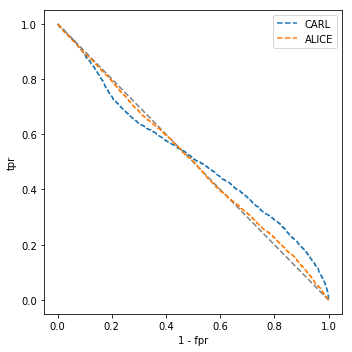

In [11]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
plt.plot(1. - fpr_train_carl, tpr_train_carl, c="C0", ls="--", label="CARL")
plt.plot(1. - fpr_train_alice, tpr_train_alice, c="C1", ls="--", label="ALICE")

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.savefig("../figures/roc.pdf")


## Evaluate on grid

In [12]:
grid_res = 25

alpha_test = np.linspace(0., 20., grid_res)
beta_test = np.linspace(-1., -3., grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [13]:
carl = ParameterizedRatioEstimator()
carl.load("../data/models/carl_log")

nllr_carl, _ = carl.log_likelihood_ratio(x=x_train[:10], theta=theta_grid)
nllr_carl = -2. * nllr_carl

09:22 inference.estimator  INFO    Creating model
09:22 inference.estimator  INFO      Architecture:           resnet
09:22 inference.estimator  INFO      Log input:              False
09:22 inference.estimator  INFO      Rescale input:          False
09:22 inference.estimator  INFO    Creating model
09:22 inference.estimator  INFO      Architecture:           resnet
09:22 inference.estimator  INFO      Log input:              True
09:22 inference.estimator  INFO      Rescale input:          True


In [14]:
alice = ParameterizedRatioEstimator()
alice.load("../data/models/alice")

nllr_alice, _ = alice.log_likelihood_ratio(x=x_train[:10], theta=theta_grid)
nllr_alice = -2. * nllr_alice

09:24 inference.estimator  INFO    Creating model
09:24 inference.estimator  INFO      Architecture:           resnet
09:24 inference.estimator  INFO      Log input:              False
09:24 inference.estimator  INFO      Rescale input:          False
09:24 inference.estimator  INFO    Creating model
09:24 inference.estimator  INFO      Architecture:           resnet
09:24 inference.estimator  INFO      Log input:              False
09:24 inference.estimator  INFO      Rescale input:          True


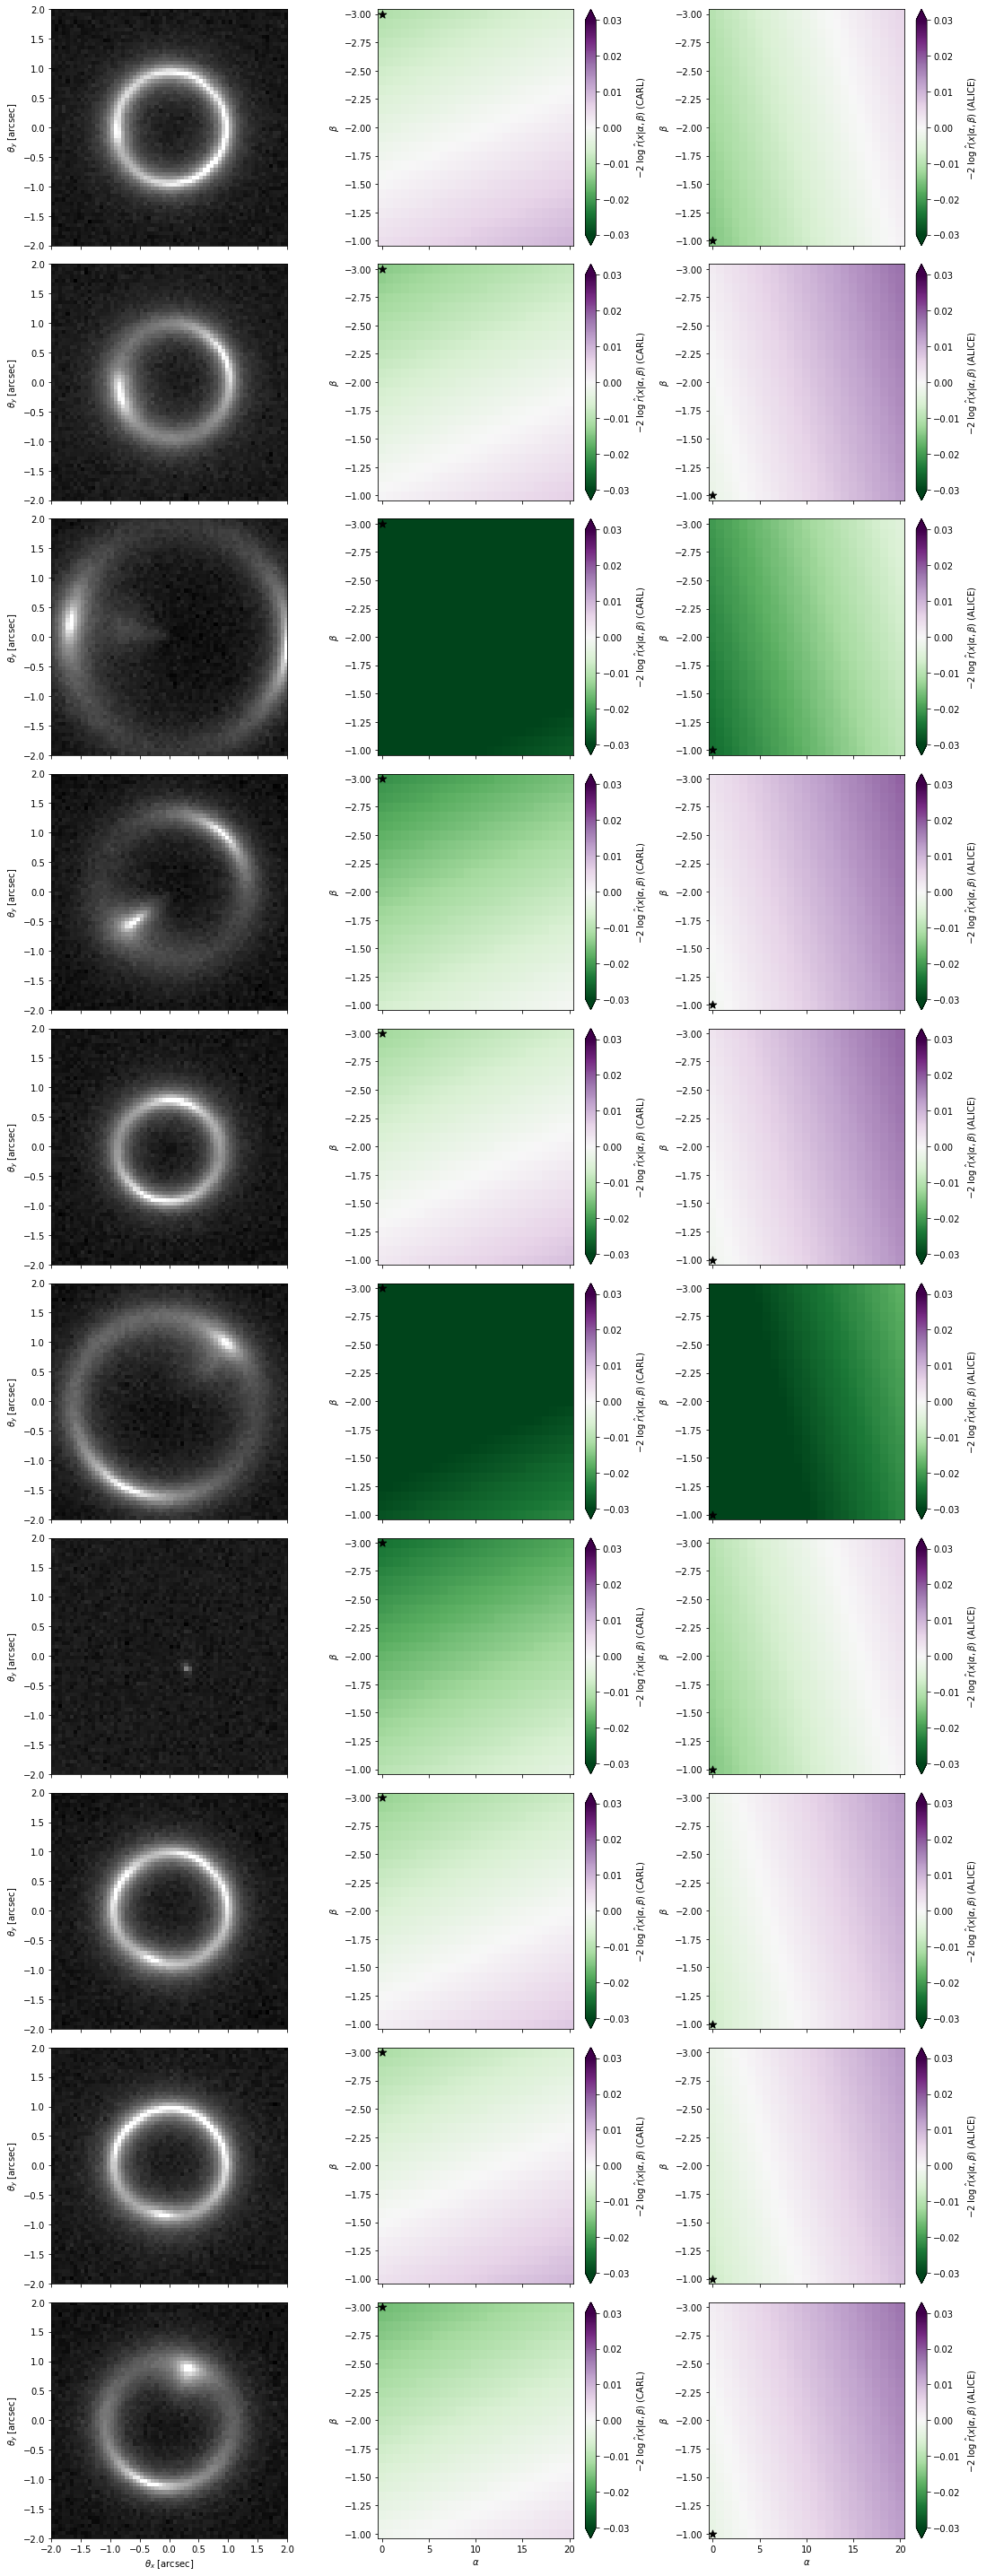

In [24]:
cmin, cmax = -.03, .03

fig = plt.figure(figsize=(5*3, 4*10))

for i in [9,0,1,2,3,4,5,6,7,8]:
    
    # Plot image
    if i == 9:
        ax_left = plt.subplot(10, 3, i*3+1)
        ax = ax_left
    else:
        ax = plt.subplot(10, 3, i*3+1, sharex=ax_left)
    
    plt.imshow(
        np.log10(x_train[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    if i == 9:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    
    # Plot estimated likelihood ratio for this image (CARL)
    if i == 9:
        ax_right = plt.subplot(10, 3, i*3+2)
        ax = ax_right
    else:
        ax = plt.subplot(10, 3, i*3+2, sharex=ax_right)
        
    nllr_ = nllr_carl[:, i]
    best_fit = theta_grid[np.argmin(nllr_)]

    bin_size = alpha_test[1] - alpha_test[0]
    alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
    bin_size = beta_test[1] - beta_test[0]
    beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        nllr_.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn_r'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

    if i == 9:
        plt.xlabel(r'$\alpha$')
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ (CARL)')
    
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])
    
    # Plot estimated likelihood ratio for this image (ALICE)
    if i == 9:
        ax_right = plt.subplot(10, 3, i*3+3)
        ax = ax_right
    else:
        ax = plt.subplot(10, 3, i*3+3, sharex=ax_right)
        
    nllr_ = nllr_alice[:, i]
    best_fit = theta_grid[np.argmin(nllr_)]

    bin_size = alpha_test[1] - alpha_test[0]
    alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
    bin_size = beta_test[1] - beta_test[0]
    beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        nllr_.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn_r'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')

    plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

    if i == 9:
        plt.xlabel(r'$\alpha$')
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ (ALICE)')
    
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])

plt.tight_layout()
plt.savefig("../figures/predictions.pdf")

## Evaluate expected LLR on grid

In [ ]:
grid_res = 25

alpha_test = np.linspace(0., 20., grid_res)
beta_test = np.linspace(-1., -3., grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [ ]:
re = ParameterizedRatioEstimator()
re.load("../data/models/debug")

nllr, _ = re.log_likelihood_ratio(x=x_test, theta=theta_grid)
expected_nllr = -2. * np.sum(nllr, axis=1)

In [ ]:
# np.save("../data/results/carl_exp_nllr.npy", expected_nllr)
expected_nllr = np.load("../data/results/carl_exp_nllr.npy")

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = plt.gca()

best_fit = theta_grid[np.argmin(expected_nllr)]
cmin, cmax = -200., 200.

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    expected_nllr.reshape((grid_res, grid_res)),
    #norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
    cmap='viridis_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlim(alpha_edges[0], alpha_edges[-1])
plt.ylim(beta_edges[0], beta_edges[-1])

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
cbar.set_label(r'$-2\; E[\log \;\hat{r}(x | \alpha, \beta)]$')

plt.tight_layout()
plt.savefig("../figures/carl_expected_llr.pdf")

In [ ]:
np.mean(theta_train, axis=0)